# Laboratory #4_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [38]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)
import os
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
from skimage.io import imread
from skimage import feature
from scipy.cluster.vq import vq
import glob
from matplotlib import pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split


## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [3]:
# modify the dataset variable with the path from your drive
dataset_path = '/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p4_2_image_classification_using_BoVW/101_ObjectCategories'

In [4]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [5]:
#solution
def get_fn_label(listoffiles):
    fn_label = []
    for category in listoffiles:
        #list of the corresponing files 
        all_files = glob.glob(dataset_path + '/' + category +'/*.jpg')
        for x in all_files: 
            fn_label.append((x,category))
    return fn_label

In [6]:
data = get_fn_label(categories)
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [9]:
# solution
df = pd.DataFrame(data)
df.columns = ['fn','label']
X = df.drop('label',axis=1)
y = df.drop('fn',axis=1)
#splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#check
print('Train set:', len(X_train))
print('Test set:', len(X_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

By using the "test_size" parameter of the train_test_split function from sklearn.model_selection

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 256 keypoints.


In [9]:
# solution
descriptor_extractor = feature.ORB(n_keypoints=256)


*   Extract ORB descriptors from all the images in the train set.


In [10]:
# solution
def all_to_gray(image): 
  try: 
    image_gray = rgb2gray(cv2.cvtColor(image, cv2.COLOR_RGBA2RGB))
  except Exception as e:
    image_gray = rgb2gray(image)
  return image_gray
#####################################################

def get_ORB(image1,n_keypoints_ = 256):
  #assume the image is not 2D
  #IMAGE_READ = plt.imread(image1)
  IMAGE1_GRAY = all_to_gray(image1)
  
  #instantiate the ORB
  DescExt = feature.ORB(n_keypoints = n_keypoints_)

  #Detect and Extract features for image 1
  DescExt.detect_and_extract(IMAGE1_GRAY)
  kpts = DescExt.keypoints
  descr = DescExt.descriptors

  return descr

# Much faster ORB feature
def cv2_ORB(image, keypoints=256):
    ORB = cv2.ORB_create(nfeatures=keypoints)
    img = cv2.imread(image)
    _, desc = ORB.detectAndCompute(img, None)
    return desc

# Running
# MUCH SLOWER
vals = X_train.values.reshape(-1,)
read_imgs = list(map(plt.imread, vals))
descr = [get_ORB(x) for x in read_imgs]

# MUCH FAST
vals_cv2 = X_train.values.reshape(-1,)
descr_cv2 = list(map(cv2_ORB, vals_cv2))

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [16]:
# solution
print(f"Single descriptor dimension {descr_cv2[0].ndim}")
print(f"Single descriptor shape {descr_cv2[0].shape}")
print(f"Image shape {read_imgs[0].shape}")

Single descriptor dimension 2
Single descriptor shape (243, 32)
Image shape (261, 300, 3)


**Solution**

OpenCV's ORB feature extractor uses BRIEF-32, which means that it stores 32 bytes for each giving a length of 256 bit (32*8). In each of the bytes it contains 8 pixel intensity comparisson, as it is explained in the original paper. So each dimensions corresponds to the corresponding pixel intensity comparisson. 

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [40]:
#stacking the descriptors 
def vStackDescriptors(descriptors_list):
    desc = np.array(descriptors_list[0])
    for d in descriptors_list[1:]:
        desc = np.vstack((desc, d))
    return desc

vstackdesc = vStackDescriptors(descr_cv2)

# solution
kmeans = MiniBatchKMeans(n_clusters=ncl,
                         random_state=42,
                         batch_size=len(X_train)//ncl,
                         max_iter=10)

kmeans = kmeans.fit(vstackdesc)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

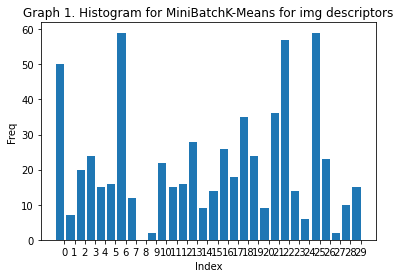

In [42]:
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 32)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Index")
    plt.ylabel("Freq")
    plt.title("Graph 1. Histogram for MiniBatchK-Means for img descriptors")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

im_features = extractFeatures(kmeans, descr_cv2,len(X_train),30)
scale = StandardScaler().fit(im_features)
im_features = scale.transform(im_features)

# solution
plotHistogram(im_features, 30)



# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [47]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [57]:
#Solution
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    Cs2 = list(np.arange(0.01,1.0, 20))
    gammas = [0.1, 0.11, 0.095, 0.105]
    gammas_2 = list(np.arange(0.08, 0.15, 20))
    param_grid = {'C': Cs2, 'gamma' : gammas_2}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    return svm

In [58]:
svm = findSVM(im_features, y_train.values.ravel(),'precomputed')

0.01 0.08


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [59]:
# solution

https://github.com/gurkandemir/Bag-of-Visual-Words/blob/df6080dec5fe227ffb1d7e47403b58401891882e/Code%20Files/BoW.py#L73

SyntaxError: invalid syntax (<ipython-input-59-9080a3466ace>, line 3)

*   Calculate the accuracy score for the classification model

In [ ]:
# solution



*   Generate the confusion matrix for the classification model

In [ ]:
# solution



*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*(Double-click or enter to edit)*

...

*   Will adding more keypoints increase the performanc of the algorithm?

**Solution**

*(Double-click or enter to edit)*

...

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [ ]:
# solution



*   What is the size of the feature descriptors?

In [ ]:
# solution



*   Create codebook using the extracted features

In [ ]:
# solution



*   Train SVM classifier using the codebook

In [ ]:
# solution



*   Evaluate the test set using the above method

In [ ]:
# solution



*   Calculate the accuracy score and confusion matrix for the classification model

In [ ]:
# solution



*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**

*(Double-click or enter to edit)*

...

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**

*(Double-click or enter to edit)*

...

*   What happens if the test image does not belong to any of the trained classes?

**Solution**

*(Double-click or enter to edit)*

...

*   Combine the features extracted using ORB and Deep Neural Network.
*   Create a codebook with the combined features
*   Train a SVM classifier using the generated codebook and evaluate the performance using accuracy and confusion matrix.

In [ ]:
# solution



*   Do the combined features increase the performance of the classifier?

**Solution**

*(Double-click or enter to edit)*

...

## t-distributed Stochastic Neighbor Embedding (Optional).

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=y_train)
plt.title("TSNE visualization")
plt.show()

*   What do you infer from the t-SNE plot?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P4_2: Image Classification using Bag of Visual Words**
Deadline for P4_2 submission in CampusVirtual is: **Monday, the 6th of December, 2021**